In [11]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [2]:
def gen_base_anchors(base_size, ratios, scales):
    w = base_size
    h = base_size
    x_ctr = 0.5 * (w - 1)
    y_ctr = 0.5 * (h - 1)


    h_ratios = torch.sqrt(ratios)
    w_ratios = 1 / h_ratios
    ws = (w * w_ratios[:, None] * scales[None, :]).view(-1)
    hs = (h * h_ratios[:, None] * scales[None, :]).view(-1)

    base_anchors = torch.stack(
        [
            x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1),
            x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)
        ],
        dim=-1).round()

    return base_anchors

In [3]:
def meshgrid(x, y):
    xx = x.repeat(len(y))
    yy = y.view(-1, 1).repeat(1, len(x)).view(-1)
    return xx, yy

In [4]:
def grid_anchors(base_anchors, featmap_size, stride=16, device='cuda'):
    base_anchors = base_anchors.to(device)

    feat_h, feat_w = featmap_size
    shift_x = torch.arange(0, feat_w, device=device) * stride
    shift_y = torch.arange(0, feat_h, device=device) * stride
    shift_xx, shift_yy = meshgrid(shift_x, shift_y)
    shifts = torch.stack([shift_xx, shift_yy, shift_xx, shift_yy], dim=-1)
    shifts = shifts.type_as(base_anchors)

    all_anchors = base_anchors[None, :, :] + shifts[:, None, :]
    all_anchors = all_anchors.view(-1, 4)
    return all_anchors, shifts

In [7]:
def prepare_base_figure(shape, grid_size, figsize=(20, 20)):    
    fig, ax = plt.subplots(figsize=figsize)

    loc = plticker.MultipleLocator(base=grid_size)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    
    ax.grid(which='major', axis='both', linestyle='--', color='w')
    return ax 


def draw_anchor_gt_overlaps(overlaps, grid_size=1, figsize=(20, 20)):    
    """Draw anchor overlaps w.r.t. gt bboxes"""
    grid_x, grid_y = overlaps.shape[:2]
    ax = prepare_base_figure(overlaps.shape, grid_size, figsize)
    ax.imshow(overlaps, extent=[0, grid_x, 0, grid_y])
    plt.margins(0)
    plt.show()

    
def draw_pos_assigned_bboxes(image_shape, grid_size, gt_bboxes_list, pos_bboxes, 
                             pos_pred_bboxes=None, figsize=(20, 20)):
    """Draw positive, negative bboxes."""
    background_image = np.zeros(image_shape)
    ax = prepare_base_figure(image_shape, grid_size, figsize)
    
    for gt_bbox in gt_bboxes_list:
        x1, y1, x2, y2 = gt_bbox
        cv2.rectangle(background_image, (x1, y1), (x2, y2), (0, 0, 255), 1)
        
    for pos_bbox in pos_bboxes:
        x1, y1, x2, y2 = pos_bbox
        cv2.rectangle(background_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    if pos_pred_bboxes is not None:
        for pos_pred_bbox in pos_pred_bboxes:
            x1, y1, x2, y2 = pos_pred_bbox
            cv2.rectangle(background_image, (x1, y1), (x2, y2), (255, 0, 0), 1)
    
    image_x, image_y = image_shape[:2]
    ax.imshow(background_image, extent=[0, image_x, 0, image_y])        
    plt.show()

    
# assume our anchor_head network predicted delta
def predict_anchor(shape):
    delta_pred = torch.randn([9216, 4])
    return delta_pred

In [5]:
base_anchor = gen_base_anchors(32, torch.Tensor([0.5, 1, 2]), torch.Tensor([2]))
board = np.zeros((256, 256, 3))
all_anchors, shifts = grid_anchors(base_anchor, (32, 32), 16)

In [25]:
from math import sqrt
print(32/sqrt(2), 32 * sqrt(2))

22.62741699796952 45.254833995939045


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1440x1440 with 0 Axes>

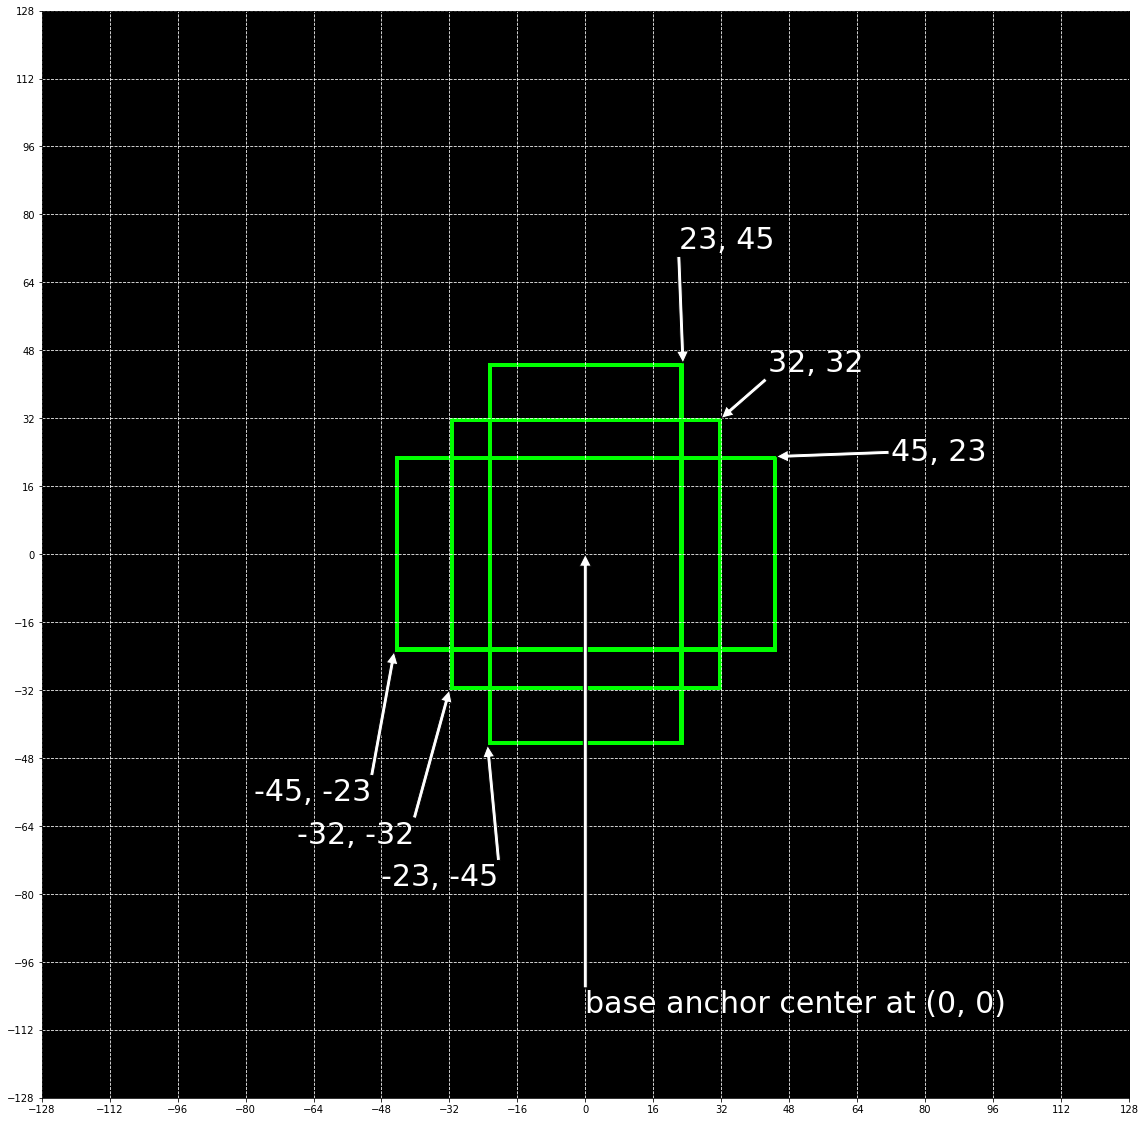

In [34]:
for anchor in base_anchor:
    x1, y1, x2, y2 = np.array(anchor) + 112
    cv2.rectangle(board, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
board[board>255] = 255
fig = plt.figure(figsize=(20,20))
ax = prepare_base_figure((1,1,1), 16)

ax.annotate('base anchor center at (0, 0)', xy=(0, 0), xytext=(0, -108), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )

ax.annotate('-23, -45', xy=(-23, -45), xytext=(-48, -78), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('-32, -32', xy=(-32, -32), xytext=(-68, -68), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('-45, -23', xy=(-45, -23), xytext=(-78, -58), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )

ax.annotate('23, 45', xy=(23, 45), xytext=(22, 72), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('32, 32', xy=(32, 32), xytext=(43, 43), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('45, 23', xy=(45, 23), xytext=(72, 22), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )

ax.imshow(board, extent=[-128, 128, -128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


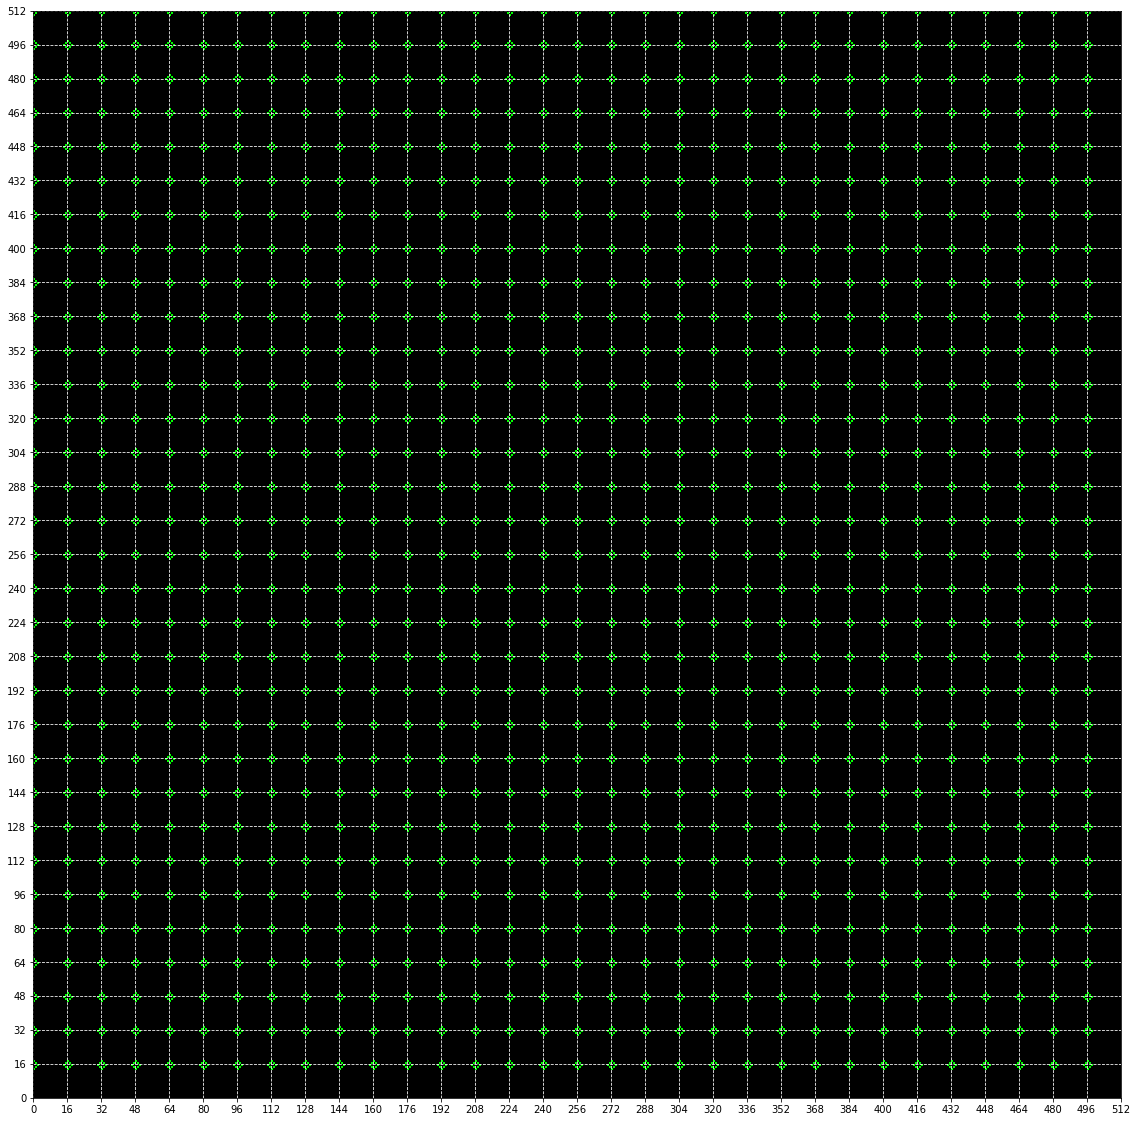

In [62]:
base_anchor = gen_base_anchors(32, torch.Tensor([0.5, 1, 2]), torch.Tensor([2, 2*2**(1/3), 2*2**(2/3)]))
board = np.zeros((512, 512, 3))
for shift in shifts.cpu():
    shift = np.array(shift, dtype=np.uint16)
    #board[shift[1], shift[0]] = (255, 255, 0)
    cv2.circle(board, (shift[3], shift[2]), 2, (0,255,0))
ax = prepare_base_figure((1,1,1), 16)
ax.imshow(board, extent=[0, 512, 0, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


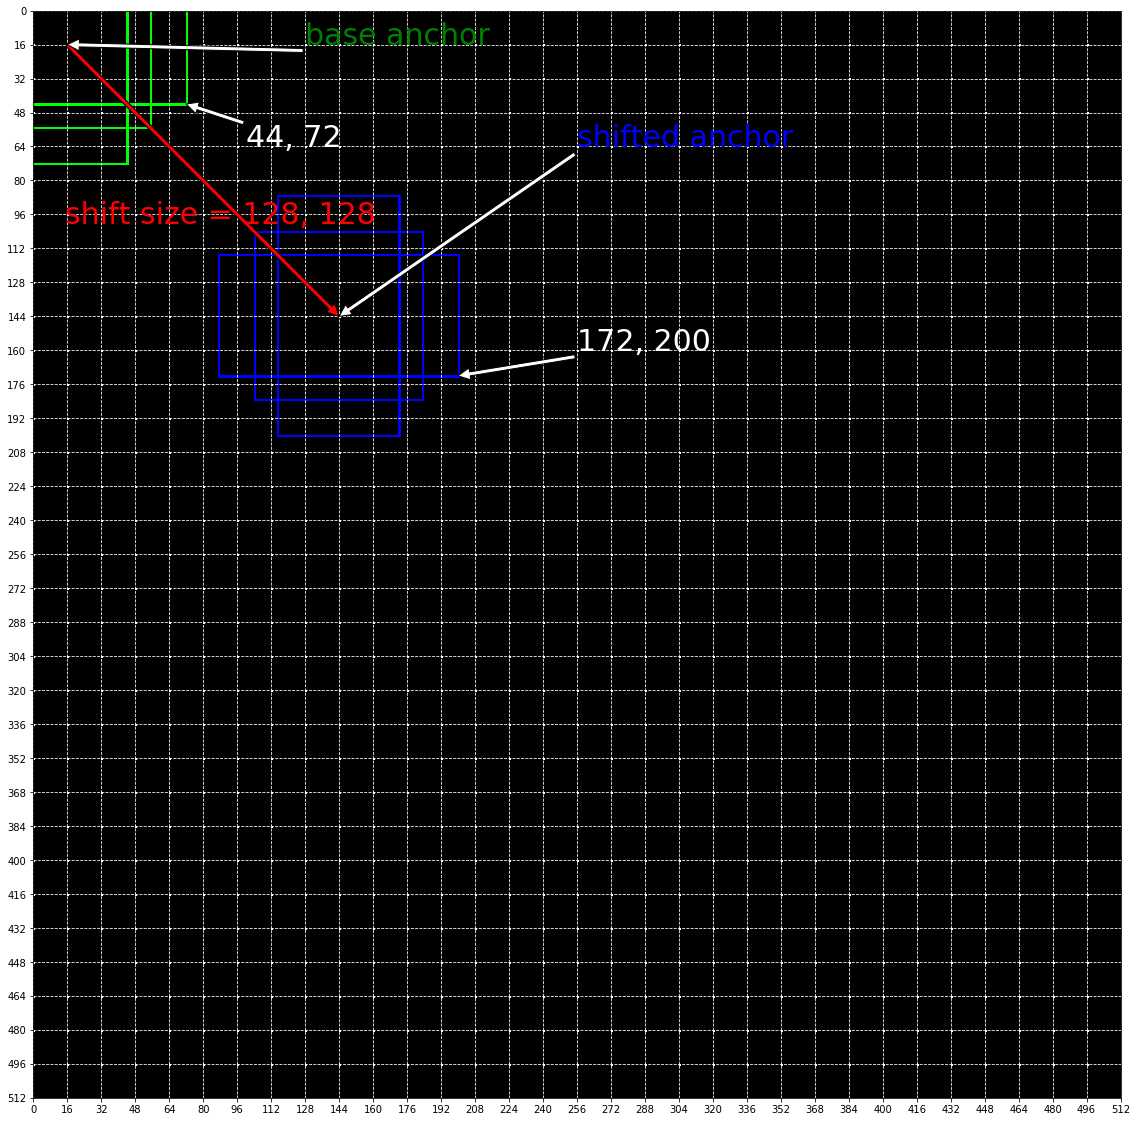

In [81]:
base_anchor = gen_base_anchors(32, torch.Tensor([0.5, 1, 2]), torch.Tensor([2*2**(1/3)]))
board = np.zeros((512, 512, 3))
ax = prepare_base_figure((1,1,1), 16)

for shift in shifts.cpu():
    shift = np.array(shift, dtype=np.uint16)
    board[shift[1], shift[0]] = 255
    board[shift[3], shift[2]] = 255
for anchor in base_anchor:
    x1, y1, x2, y2 = np.array(anchor)
    cv2.rectangle(board, (x1, y1), (x2, y2), (0, 255, 0), 1)
    x1, y1, x2, y2 = np.array(anchor) + 128
    cv2.rectangle(board, (x1, y1), (x2, y2), (0, 0, 255), 1)
board[board>255] = 255

show_anchor = np.array(base_anchor[2])
moved_show_anchor = np.array(base_anchor[2]) + 128


ax.annotate('', xy=(144, 144), xytext=(16, 16), color='white',size=30,
            arrowprops=dict(facecolor='red', shrink=5),
            )
ax.annotate('shift size = 128, 128', xy=(16, 128), xytext=(15, 100), color='red',size=30
            )
ax.annotate('shifted anchor = 144,', xy=(144, 144), xytext=(256, 64), color='blue',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('base anchor', xy=(16, 16), xytext=(128, 16), color='green',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('172, 200', xy=(moved_show_anchor[3], moved_show_anchor[2]), xytext=(256, 160), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.annotate('44, 72', xy=(show_anchor[3], show_anchor[2]), xytext=(100, 64), color='white',size=30,
            arrowprops=dict(facecolor='white', shrink=5),
            )
ax.imshow(board, extent=[0, 512, 512, 0])